### Styling of Markdown output

In [1]:
%%HTML
<style>
  @import url('https://fonts.googleapis.com/css2?family=JetBrains+Mono&display=swap');

  body {
    font-family: 'JetBrains Mono', -apple-system, BlinkMacSystemFont, 'Segoe WPC', 'Segoe UI', system-ui, 'Ubuntu', 'Droid Sans', sans-serif;
    line-height: 1.67;
  }
</style>


# Closed Loop System Simulator under a Dynamic ETM

This notebook presents an analysis of the effectiveness of Event-Triggered Control (ETC) co-design conditions, as proposed by Coutinho in his research [1]. The aim is to reproduce the results obtained by Coutinho in his study, providing a detailed insight into the performance and robustness of the control system under dynamic event-triggering conditions.

## Importing the Libraries

To perform this analysis, we utilize several essential libraries for modeling, simulation, and visualization of control systems. The imported libraries are:

- **NumPy (np)**: A fundamental package for scientific computing with Python. It supports large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.

- **Matplotlib (plt)**: A plotting library for Python and its numerical mathematics extension, NumPy. It provides an object-oriented API for embedding plots into applications using general-purpose GUI toolkits and is used here to create plots and visualize the simulation results.

- **Control (ct)**: A library that provides functions and classes to facilitate the modeling, simulation, and analysis of dynamic systems. It supports a wide range of systems and control design techniques, making it a valuable tool for control engineers.

Additionally, the following configurations are set:

- `ct.use_matlab_defaults()`: Configures the `Control` library to use MATLAB-like default settings, which can be helpful for users familiar with MATLAB.

- `%config InlineBackend.figure_format='retina'`: Configures the Jupyter notebook backend to render figures in high resolution, ensuring better visual quality for the generated plots.

Next, we will begin by importing these libraries and configuring the environment for the necessary simulations.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct
ct.use_matlab_defaults()
%config InlineBackend.figure_format='retina'

## Van der Pol Oscillator System

### System Definition

The system to be analyzed is the forced Van der Pol oscillator, which is described as follow:

$$
\begin{aligned}
  \dot{x_1}(t) &= x_2(t) \\
  \dot{x_2}(t) &= (1-x_1^2(t))x_2(t) - x_1(t) + u(t)
  \tag{1}
\end{aligned}
$$

where the modeling region is assumed to be $\mathscr{D} = \{x \in \mathbb{R}^2 : |x_i| \leq r_0, i \in \mathbb{N}_{\leq2}\}$. The equations in Eq. 1 can be rewritten as:

$$
\begin{bmatrix}
  \dot{x}_1(t) \\
  \dot{x}_2(t)
\end{bmatrix}
=
\begin{bmatrix}
  0 & 1 \\
  -1 & 1 - x_1^2(t)
\end{bmatrix}
\begin{bmatrix}
  x_1(t) \\
  x_2(t)
\end{bmatrix}
+
\begin{bmatrix}
  0 \\
  1
\end{bmatrix}
u(t)
\tag{2}
$$

By selecting the scheduling function $z_1(x) = x_1^2$, which is bounded within $\mathscr{D}$ by $z^0=0$ e $z^1=r_0^2$, the matrices $A(x)$ and $B(x)$ can be written as:

$$A(x) = \begin{bmatrix} 0 & 1 \\ -1 & 1\end{bmatrix} + z_1(x) \begin{bmatrix} 0 & 0\\ 0 & -1\end{bmatrix}, \hspace{0.2cm} \text{e} \hspace{0.2cm} B(x) = \begin{bmatrix} 0 \\ 1 \end{bmatrix} + z_1(x) \begin{bmatrix}0 \\ 0\end{bmatrix} \tag{3}$$

Then, following the sector non-linearity approach, the system (1) can be represented in $\mathscr{D}$ by following polytopic quasi-LPV model:

$$\dot{x}(t) = \sum_{i = 0}^1 w_i(x)(A_ix(t)+B_iu(t))$$

where the state-dependent parameters are:

$$
  w_0(x)=\frac{r_0^2-x_1^2(t)}{r_0^2}, \hspace{0.33cm} w_1(x)=1-w_0(x), 
  \tag{4}
$$

and the vertex matrices are:

$$
\begin{aligned}
  A_0 = \begin{bmatrix}
    0 & 1 \\
    -1 & 1
  \end{bmatrix},
  \hspace{1cm}
  &

  B_0 = \begin{bmatrix}
    0 \\ 1
  \end{bmatrix},
  
  \\ \\

  A_1 = \begin{bmatrix}
    0 & 1 \\
    -1 & 1 - r_0^2
  \end{bmatrix},
  \hspace{1cm}
  &
  B_1 = \begin{bmatrix}
    0 \\ 1
  \end{bmatrix}
  .
  \tag{5}
\end{aligned}
$$

### System Implementation

The following code presents the implementation of the oscillatory system. The systems is defined by the following variables and functions:

- Variables:
  - $r_0$: modeling region parameter
  - $U$: system input
  - $X0$: initial states
  - $A$: system states matrices
  - $B$: system input matrices

- Functions:
  - ```get_w(x)```: the function that calculates the state-dependent parameters for the linear combination of matrices $A$ and $B$, based on current state $x$ of system.
  - ```oscillator_update(t, x, u, params)```: the update function of system that calculates the derivative of the system state at time $t$, based on current state $x$, system input $u$ and system parameters.

The system is modeled as a state-space system using the python library '''control (ct)'''. The function ```ct.ss()``` is used to define the system, where:
- ```oscillator_update``` is the update function of system;
- ```None``` indicates that the system output consists of all its states;
- The system name is 'oscillator'
- The input system is **'u'**
- The outputs system are **'x1'** and **'x2'**
- The states system are **'x1'** and **'x2'**

This implementation allows for the simulation and study the dynamic behavior of forced Van der Pol oscillator.

In [3]:
r0 = 5
A = [np.array([[0, 1], [-1, 1]]), np.array([[0, 1], [-1, 1 - r0 ** 2]])]
B = [np.array([[0], [1]]), np.array([[0], [1]])]


def get_w(x):
  w0 = (r0 ** 2 - x[0] ** 2) / (r0 ** 2)
  w1 = 1. - w0
  return [w0, w1]


def oscillator_update(t, x, u, params):
  w = get_w(x)
  x_dot = 0
  for i in range(len(w)):
    x_dot += w[i] * (A[i] @ x + B[i] @ u)
  return x_dot


oscillator = ct.ss(
    oscillator_update, None,
    name='oscillator',
    inputs=('u'),
    outputs=('x1', 'x2'),
    states=('x1', 'x2'),
)

### System Simulation

The code below performs the simulation previously defined system. It uses the `input_output_response` function from control (ct) library to simulate the system's response to a specific input over time. The parameters used for the simulation are as follows:

- `sys`: the system to be simulated, which was previously defined as the forced Van der Pol Oscillator.
- `T`: time vector which defines the simulation time interval, with a step size of `step`, ranging from 0 to 30.
- `U`: input vector defined as `[0.1]`.
- `X0`: initial states vector defined as `[4.2467, 1.1155]`.

The simulation returns two time series `t` and `y`, representing the time and the system response, respectively. These data can be used to analyze the dynamic behavior of the system over time.

In [4]:
step = 1e-2
tf = 30
timepts = np.arange(0, tf + step, step)
U = [.1]
X0 = [4.2467, 1.1155]

t, y = ct.input_output_response(
    sys=oscillator, T=timepts,
    U=U, X0=X0,
)

### Presentation of Results: Open Loop Simulation

The code below uses the Matplotlib library to create a plot with two subfigures, each representing a state of the dynamic Van der Pol oscillator system. The `set_axs` function is defined to consistently configure the visual properties of the plots. This function takes the following parameters:

- `axs`: the axes of the plot where the data will be plotted.
- `x`: the x-axis data, representing time.
- `y`: the y-axis data, representing the states of the system.
- `label`: the legend of the plot.
- `x_label`: the label for the x-axis.
- `y_label`: the label for the y-axis.
- `title`: the title of the plot.

Then, a figure with two subfigures is created using `plt.subplots()`, where `figsize=(12, 4)` defines the size of the figure. Two plots are generated, one for each state of the system, using the `set_axs` function to set their visual properties.

- Plot 1: represents the state $x_1$ of the system over time.
- Plot 2: represents the state $x_2$ of the system over time.

Finally, the overall title of the figure is set to "Van der Pol Oscillatory Dynamic System" using `fig.suptitle()`, and the `plt.tight_layout()` function ensures that the layout of the plots is appropriate before displaying them with `plt.show()`. These plots allow for visualizing the evolution of the system states over time and presenting the results clearly and organized.

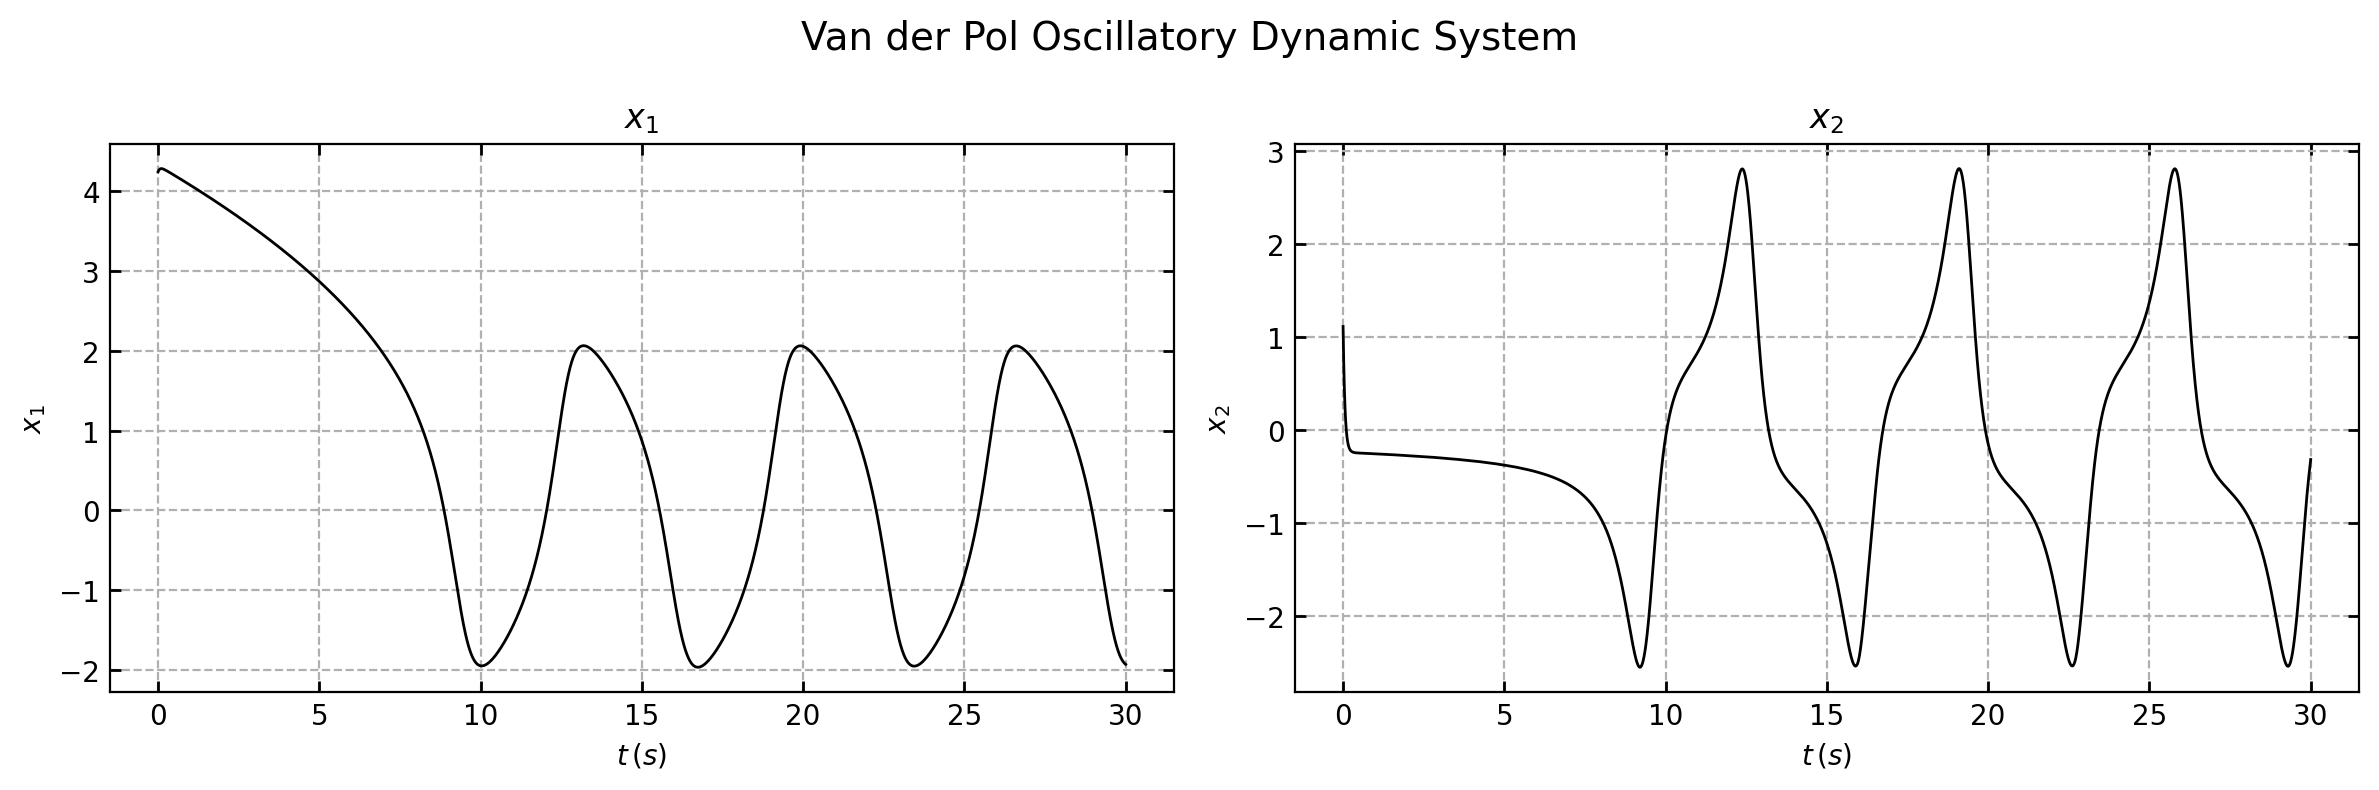

In [5]:
def set_axs(axs, x, y, label, x_label, y_label, title):
  axs.plot(x, y, linestyle='-', color='black', label=label, linewidth=1.)
  axs.set_xlabel(x_label)
  axs.set_ylabel(y_label)
  axs.set_title(title)
  # axs.legend()
  axs.grid(linestyle='--')
  axs.tick_params(axis='both', direction='in', length=4, width=1,
                  colors='black', grid_alpha=1., top=True, right=True)


fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1 - State x1
set_axs(axs[0], t, y[0], '$x_1$', '$t \, (s)$', '$x_1$', '$x_1$')

# Plot 2 - State x2
set_axs(axs[1], t, y[1], '$x_2$', '$t \, (s)$', '$x_2$', '$x_2$')

fig.suptitle('Van der Pol Oscillatory Dynamic System', fontsize=14)

plt.tight_layout()
plt.show()

## Event-Triggered Control Model

<!-- The control model employs an Event-Triggered Mechanism (ETM) to optimize control actions while minimizing computational resources. The system comprises a nonlinear plant $P$ described by:

$$ \dot{x} = A(x(t)) x(t) + B(x(t)) u(t) $$

where $x(t) \in \mathcal{D} \subset \mathbb{R}^n$ are the system states and $u(t) \in \mathcal{D} \subset \mathbb{R}^m$ is the control input. $A : \mathcal{D} \rightarrow \mathbb{R}^{n\times n}$ and $B : \mathcal{D} \rightarrow \mathbb{R}^{n\times m}$, $B(x) \neq 0, \forall x \in \mathcal{D}$, are continuous matrix-valued functions  The state feedback control law is given by:

$$ u(t) = K\hat{x}(t) $$

The ETM determines when to transmit the plant's state to the controller over a network, maintaining the state with a Zero-Order Hold (ZOH) until the next transmission, leading to a potential transmission error:

$$ e(t) = \hat{x}(t) - x(t), \quad \forall t \in [t_k, t_{k+1}) $$

<p align="center">
	<img src="../assets/etc-model.svg" alt="Event-triggered Control Model" style="max-width:100%; height:260px;"/> 
	<br>
	<strong>Figure 3:</strong> Event-triggered Control Model
</p>

### ETM Models and Optimization

**Static Event-Triggered Mechanism**

The static ETM has a fixed activation function:

$$ t_{k+1} = \inf \{ t > t_k : \Gamma(x(t), e(t)) < 0 \} $$

where the triggering function is:

$$ \Gamma(x(t), e(t)) = x^T(t) \Psi x(t) - e^T(t)\Xi(t) $$

**Dynamic Event-Triggered Mechanism**

The dynamic ETM includes an internal dynamic variable:

$$ t_{k+1} = \inf \{t > t_k : \eta(t) + \theta \Gamma(x(t), e(t)) < 0 \} $$

with the internal variable dynamics:

$$ \dot{\eta} = -\lambda \eta(t) + \Gamma(x(t), e(t)) $$

**Optimization for ETM Design**

The optimization problem to determine the matrices $\Xi$, $\Psi$, and $K$ is formulated as:

$$
\underset{X, \tilde{\Xi}, \tilde{\Psi}, \tilde{K}}{\min} \quad \mathrm{tr}\left(\rho \tilde{\Xi} + (1 - \rho)\tilde{\Psi}\right)
$$
$$
\text{subject to} \quad 10^{-\mu} \mathrm{I} \leq \tilde{\Xi} \leq 10^{\mu} \mathrm{I}, \quad 10^{-\mu} \mathrm{I} \leq \tilde{\Psi} \leq 10^{\mu} \mathrm{I}
\hspace{0.5cm} \mathrm{e} \hspace{0.5cm}
\begin{bmatrix}
\mathsf{He}(AX + B\tilde{K}) & B\tilde{K}   & X             \\
\star                       & -\tilde{\Xi} & 0             \\
\star                       & \star        & -\tilde{\Psi}
\end{bmatrix} < 0
$$

The matrices are obtained as $K = \tilde{K}X^{-1}$, $\Xi = X^{-1}\tilde{\Xi}X^{-1}$, and $\Psi = \tilde{\Psi}^{-1}$. -->

### Dynamic ETM Implementation  

In [6]:
K = [np.array([[-0.559, -3.5]]), np.array([[-6.05, -3.01]])]
Ξ = np.array([[1.36, 1.34], [1.34, 6.39]])
Ψ = np.array([[0.951, 0.333], [0.333, 1.81]])
P = np.array([[2.08e+00, 4.10e-01], [4.10e-01, 1.83e+00]])

θ = 1
λ = 0.1

event_times = []


def get_gama(current_states, last_states_sent):
  w_x = get_w(current_states)
  w_ex = get_w(last_states_sent)
  error = last_states_sent - current_states

  K_x, K_ex, B_x = 0, 0, 0
  for i in range(len(w_x)):
    K_x += w_x[i] * K[i]
    K_ex += w_ex[i] * K[i]
    B_x += w_x[i] * B[i]

  ζ = 2 * current_states.T @ P @ B_x @ (K_ex - K_x) @ last_states_sent
  return current_states.T @ Ψ @ current_states - error.T @ Ξ @ error - ζ


def etm_update(t, n, u, params):
  Γ = get_gama(current_states=u[2:4], last_states_sent=u[0:2])
  dλ = -λ * n + Γ
  return [dλ]


def etm_output(t, n, u, params):
  global zero, event_times

  if t != etm_output.previous_time:
    etm_output.previous_time = t
    if etm_output.first_simulation and t == 0.:
      etm_output.first_simulation = False

  last_states_sent = u[0:2]
  current_states = u[2:4]

  Γ = get_gama(current_states, last_states_sent)
  trigger = (n + θ * Γ) < 0

  if etm_output.first_simulation and trigger:
    event_times.append(t)

  state_to_sent = (current_states if trigger or t == 0. else last_states_sent)
  return [trigger[0], state_to_sent[0], state_to_sent[1], n[0]]


etm_output.previous_time = 0
etm_output.first_simulation = True

ETM = ct.NonlinearIOSystem(
    etm_update, etm_output,
    name='etm',
    states=('n'),
    inputs=('x1_hat', 'x2_hat', 'x1', 'x2'),
    outputs=('Γ', 'x1', 'x2', 'n'),
)


def zoh_output(t, x, u, params):
  if t != zoh_output.previous_time:
    zoh_output.last_states_sent = zoh_output.previous
    zoh_output.previous_time = t
  zoh_output.previous = u
  return zoh_output.last_states_sent


zoh_output.previous_time = 0
zoh_output.previous = []
zoh_output.last_states_sent = [0, 0]

ZOH = ct.ss(
    None, zoh_output,
    name='zoh',
    inputs=('x1', 'x2'),
    outputs=('x1_hat', 'x2_hat'),
)


def control_output(t, x, u, params):
  states_received = u
  w = get_w(states_received)

  duty_cycle = 0
  for i in range(len(w)):
    duty_cycle += w[i] * K[i] @ states_received

  return [duty_cycle]


CONTROL = ct.NonlinearIOSystem(
    None, control_output,
    name='control',
    inputs=('x1_hat', 'x2_hat'),
    outputs=('u'),
)

CLOSED_LOOP_SYSTEM = ct.interconnect(
    (oscillator, ETM, ZOH, CONTROL),
    connections=(
        # Connection between controller output and plant
        ('oscillator.u', 'control.u'),

        # Connection between ZOH and plant outputs to ETM
        ('etm.x1_hat', 'zoh.x1_hat'),
        ('etm.x2_hat', 'zoh.x2_hat'),
        ('etm.x1', 'oscillator.x1'),
        ('etm.x2', 'oscillator.x2'),

        # Connecting the ETM output to the ZOH
        ('zoh.x1', 'etm.x1'),
        ('zoh.x2', 'etm.x2'),

        # Connecting the ZOH output to the controller
        ('control.x1_hat', 'zoh.x1_hat'),
        ('control.x2_hat', 'zoh.x2_hat'),
    ),
    name='closed-loop system',
    outlist=('oscillator.x1',
             'oscillator.x2',
             'etm.Γ',
             'etm.n',
             'oscillator.u',
             ),
    output=('x1', 'x2', 'Γ', 'n', 'u')
)

print(CLOSED_LOOP_SYSTEM)
print('')

step = 1e-4
timepts = np.arange(0, 30 + step, step)
t, y = ct.input_output_response(
    sys=CLOSED_LOOP_SYSTEM, T=timepts,
    X0=[4.2467, 1.1155, 0],
    solve_ivp_method='RK45',
    solve_ivp_kwargs={'max_step': step}
)

inter_event_times = []

for i in range(1, len(event_times)):
  inter_event_times.append(event_times[i] - event_times[i-1])

<InterconnectedSystem>: closed-loop system
Inputs (0): []
Outputs (5): ['x1', 'x2', 'Γ', 'n', 'u']
States (3): ['oscillator_x1', 'oscillator_x2', 'etm_n']



### Oscillator Under Dynamic ETM Results

In [7]:
figsize = (8, 4)

# Gráfico 1: Estado do Sistema x1
plt.figure(figsize=figsize)
set_axs(plt.gca(), t, y[0], '$x_1$', '$t\,(s)$',
        '$x_1$', 'Estado do Sistema $x_1$')
plt.savefig('../assets/van-der-pol/dynamic-etm/state-x1.svg', format='svg')
plt.close()

# Gráfico 2: Estado do Sistema x2
plt.figure(figsize=figsize)
set_axs(plt.gca(), t, y[1], '$x_2$', '$t\,(s)$',
        '$x_2$', 'Estado do Sistema $x_2$')
plt.savefig('../assets/van-der-pol/dynamic-etm/state-x2.svg', format='svg')
plt.close()

# Gráfico 3: Estado n
plt.figure(figsize=figsize)
set_axs(plt.gca(), t, y[3], '$n', '$t\,(s)$', '$n$', 'Estado $n$')
plt.savefig('../assets/van-der-pol/dynamic-etm/state-n.svg', format='svg')
plt.close()

# Gráfico 4: Entrada do Sistema u
plt.figure(figsize=figsize)
set_axs(plt.gca(), t[1:], y[4][1:], '$u$', '$t\,(s)$',
        '$u$', 'Entrada do Sistema $u$')
plt.savefig('../assets/van-der-pol/dynamic-etm/input-u.svg', format='svg')
plt.close()

# Gráfico 5: Inter-event times
plt.figure(figsize=figsize)
plt.stem(event_times[1:], inter_event_times,
         linefmt='black', markerfmt='o', basefmt=' ', bottom=0)
plt.xlabel('$t\,(s)$')
plt.ylabel('inter-event times')
plt.title('Inter-event times')
plt.grid(linestyle='--')
plt.savefig(
    '../assets/van-der-pol/dynamic-etm/inter-event-times.svg', format='svg')
plt.close()

### System States

The figures below presents the temporal evolution of the system states over time, represented on the horizontal axis. The states $x_1$ and $x_2$ are plotted as functions of time $t$, demonstrating the changes in the system over a specific time interval. Tha axes are labeled accordingly with the horizontal axis representing time in seconds and the vertical axis representing the states. This plot provides a clear and concise visualization of the system dynamic in relation to the states $x_1$ and $x_2$.


<p align="center" style="padding: 24px;">
    <img src="../assets/van-der-pol/dynamic-etm/state-x1.svg" alt="" style="width:45%; height:100%;"/>
    <img src="../assets/van-der-pol/dynamic-etm/state-x2.svg" alt="" style="width:45%; height:100%;"/>
</p>

The next figure displays the temporal evolution of the internal dynamic variable of ETM. The horizontal axis represents time in seconds, while the vertical axis represents the state $n$ of system.

<p align="center" style="padding: 24px;">
    <img src="../assets/van-der-pol/dynamic-etm/state-n.svg" alt="" style="width:45%; height:100%;"/>
</p>


### System Input $u$

The figure below shows the input $u$ applied to dynamic system as a function of time. The horizontal axis represents the time in seconds, while the vertical axis representing the input $u$. This graph provides the visual understanding of input supplied to the system as determined by the controller and the dynamic ETM.   

<p align="center" style="padding: 24px;">
    <img src="../assets/van-der-pol/dynamic-etm/input-u.svg" alt="" style="width:45%; height:100%;"/>
</p>

### Inter-event Times

Finally, the following figure presents the inter-event times (IETs). The IETs are plotted in respect to time on the horizontal axis and the duration of IETs on the vertical axis.

<p align="center" style="padding: 24px;">
    <img src="../assets/van-der-pol/dynamic-etm/inter-event-times.svg" alt="" style="width:45%; height:100%;"/>
</p>
